In [22]:
import anndata
import scanpy as sc
import numpy as np
from sklearn.decomposition import PCA as pca
import argparse
from kmeans import KMeans
import importlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as skm

In [6]:
def my_euclidean_distance(X1:np.ndarray, X2:np.ndarray):
    """
    Computes the euclidean distance between all pairs (x,y) where x is a row in X1 and y is a row in X2.
    Tip: Using vectorized operations can hugely improve the efficiency here.
    :param X1:
    :param X2:
    :return: Returns a matrix `dist` where `dist_ij` is the distance between row i in X1 and row j in X2.
    """
    # your code
    # print((X1[:, :, None] - X2[:, :, None].T).sum(axis=1))
    return np.sqrt(((X1[:, :, np.newaxis] - X2[:, :, np.newaxis].T) ** 2).sum(axis=1))


In [3]:
def read_data(data_path):
    return anndata.read_csv(data_path)

def preprocess_data(adata: anndata.AnnData, scale :bool=True):
    """Preprocessing dataset: filtering genes/cells, normalization and scaling."""
    sc.pp.filter_cells(adata, min_counts=5000)
    sc.pp.filter_cells(adata, min_genes=500)

    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    adata.raw = adata

    sc.pp.log1p(adata)
    if scale:
        sc.pp.scale(adata, max_value=10, zero_center=True)
        adata.X[np.isnan(adata.X)] = 0

    return adata


def PCA(X, num_components: int):
    return pca(num_components).fit_transform(X)


In [4]:
heart = read_data('Heart-counts.csv')
heart = preprocess_data(heart)
X = PCA(heart.X, 100)

D:\ProgramData\Anaconda3\envs\pytorch19\lib\site-packages\anndata\core\anndata.py:1239: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(df_full[k]):


In [56]:
X.min()

-67.324196

In [35]:
asd = X[0].reshape(1, -1)
np.dot(asd, asd.T)

array([[1609.2766]], dtype=float32)

In [70]:
# euclidean_distances(X[0].reshape(1, -1), X[1].reshape(1, -1))
euclidean_distances(X[0:3], X[4:6])

array([[32.709743, 61.2192  ],
       [61.31806 , 67.639244],
       [59.660927, 69.77965 ]], dtype=float32)

In [99]:
# my_euclidean_distance(X[0].reshape(1, -1), X[1].reshape(1, -1))
asd = my_euclidean_distance(X[0:3], X[4:6]).min(axis=0)
p = asd / asd.sum()
np.arange(p.shape[0])
# np.random.choice(np.arange(p.shape[0]), p=p)


array([0, 1])

In [107]:
asd = np.random.randint(0, 2, size=(10, 10))
asd[asd == 1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [21]:
asd.shape

(3, 2)

In [111]:
asd = np.random.uniform(low=X.min(), high=X.max(), size=(7, X.shape[1]))

In [112]:
asd[0] = np.random.uniform(low=X.min(), high=X.max(), size=(1, X.shape[1]))

In [12]:
dist = my_euclidean_distance(X[0].reshape(1, -1), X)
# dist[dist != dist.min(axis=0)].shape
dist.shape

array([[ 0.      , 62.467075, 56.638546, ..., 82.71704 , 85.479515,
        97.261475]], dtype=float32)

In [123]:
X.shape

(4532, 100)

In [137]:
dist.shape

(4532, 4532)

In [132]:
euclidean_distance(X, X)

0.0

In [139]:
label = np.random.randint(0, 10, size=4532)
label

array([1, 8, 2, ..., 8, 1, 5])

In [141]:
label_freqs = np.bincount(label)
label_freqs

array([457, 465, 450, 446, 450, 474, 459, 444, 457, 430], dtype=int64)

In [143]:
clust_dists = np.zeros((len(dist), len(label_freqs)))
clust_dists.shape

(4532, 10)

In [144]:
len(dist)

4532

In [145]:

for i in range(len(dist)):
    clust_dists[i] += np.bincount(
        label, weights=dist[i], minlength=len(label_freqs)
    )

In [147]:
clust_dists[0]

array([25680.75213814, 25618.05793381, 25826.43040085, 25457.88317871,
       25963.82715225, 26893.47020531, 26358.86603928, 24659.78367424,
       25955.48279953, 25079.98959351])

In [149]:
intra_index = (np.arange(len(dist)), label[0 : 0 + len(dist)])

In [153]:
intra_index

(4532,)

In [157]:
clust_dists[np.arange(len(dist)), label]

array([25618.05793381, 30387.77679825, 31404.04283524, ...,
       36066.73100281, 32061.91535568, 45564.81842041])

In [161]:
(label_freqs - 1).take(label).shape

(4532,)

In [168]:
(clust_dists / label_freqs).min(axis=1).shape

(4532,)

In [165]:
clust_dists

array([[25680.75213814, 25618.05793381, 25826.43040085, ...,
        24659.78367424, 25955.48279953, 25079.98959351],
       [30247.99394989, 30256.93499756, 29769.78949547, ...,
        29490.08255196, 30387.77679825, 29367.8493309 ],
       [31709.27319717, 32054.36026382, 31404.04283524, ...,
        30906.47840881, 31988.44322777, 30480.90904236],
       ...,
       [36359.65784836, 36690.93901825, 35801.79647446, ...,
        35498.25120926, 36066.73100281, 34423.17435074],
       [31613.8579216 , 32061.91535568, 31438.57263088, ...,
        31362.57011032, 31828.82009888, 30233.05253601],
       [44076.81950378, 44706.77062798, 43382.32919312, ...,
        43059.22091675, 43804.4527874 , 41445.88541031]])

In [166]:
label_freqs

array([457, 465, 450, 446, 450, 474, 459, 444, 457, 430], dtype=int64)

In [42]:
X[np.random.choice(X.shape[0], 9, replace=False)].shape

(9, 100)

In [25]:
# importlib.reload(kmeans)
from kmeans import KMeans

NameError: name 'kmeans' is not defined

In [19]:

km = KMeans(n_clusters=9, init='random', max_iter=300)
labels = km.fit(X)
# km.silhouette(labels, X)

In [48]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [20]:
silhouette_score(X, labels)

0.12951893

In [21]:
km.silhouette_1(labels, X)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [96]:
ran_scores = []
kmpp_scores = []
for k in range(2, 10):
    ran_km = KMeans(n_clusters=k, init='random')
    labels = ran_km.fit(X)
    score = silhouette_score(X, labels)
    ran_scores.append(score)

    kmpp = KMeans(n_clusters=k, init='kmeans++')
    labels = kmpp.fit(X)
    score = silhouette_score(X, labels)
    kmpp_scores.append(score)

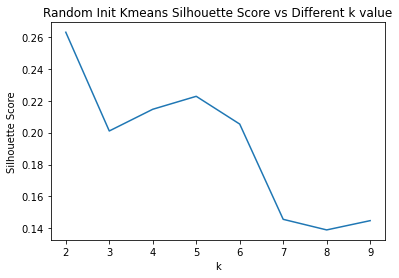

In [102]:
fig, ax = plt.subplots()
ax.plot(np.arange(2, 10), ran_scores)
ax.set_xlabel('k')
ax.set_ylabel('Silhouette Score')
ax.set_title('Random Init Kmeans Silhouette Score vs Different k value')
plt.savefig('Task2.png')
plt.show()

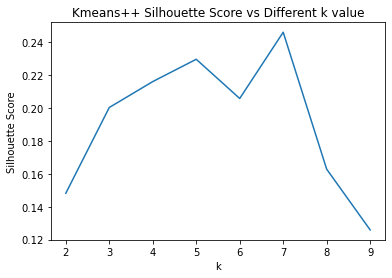

In [101]:
fig, ax = plt.subplots()
ax.plot(np.arange(2, 10), kmpp_scores)
ax.set_xlabel('k')
ax.set_ylabel('Silhouette Score')
ax.set_title('Kmeans++ Silhouette Score vs Different k value')
plt.savefig('Task3.png')
plt.show()

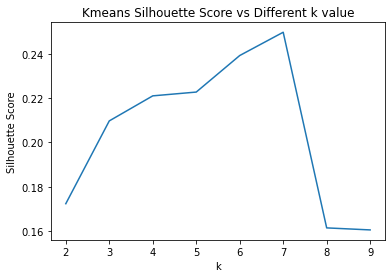

In [84]:
skl_scores = []
for k in range(2, 10):
    model = skm(n_clusters=k)
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    skl_scores.append(score)

fig, ax = plt.subplots()
ax.plot(np.arange(2, 10), skl_scores)
ax.set_xlabel('k')
ax.set_ylabel('Silhouette Score')
ax.set_title('Kmeans Silhouette Score vs Different k value')
plt.show()

In [70]:
X_2 = PCA(heart.X, 2)

In [103]:
model = KMeans(n_clusters=2, init='random')
labels = model.fit(X_2)

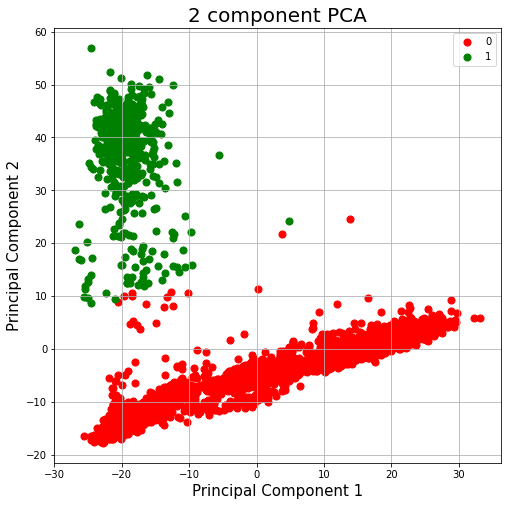

In [104]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = np.unique(labels)
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
colors = colors[:len(targets)]
for target, color in zip(targets,colors):
    row_index = labels == target
    ax.scatter(X_2[row_index, 0]
               , X_2[row_index, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.savefig('Task4.png')

7